In [11]:
import os 
import sys 
running_path = "/Odyssey/private/o23gauvr/code/FASCINATION/"
os.chdir(running_path)
sys.path.insert(0,running_path)

In [ ]:
import torch
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import hydra
from omegaconf import OmegaConf
from IPython.display import Markdown, display
import yaml
import numpy as np  


In [13]:
plt.style.use('ggplot')

In [14]:
cmap = plt.get_cmap('viridis')

In [15]:
gpu = 0
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [16]:
data_path = "/Odyssey/public/enatl60/celerity/eNATL60_BLB002_sound_speed_regrid_0_botm.nc"
#data_path = "/Odyssey/public/enatl60/celerity/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc"

In [17]:
da = xr.open_dataarray(data_path)
da

<xarray.DataArray 'celerity' (time: 365, z: 300, lat: 240, lon: 240)>
[6307200000 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -65.95 -65.9 -65.85 -65.8 ... -54.1 -54.05 -54.0
  * lat      (lat) float64 32.0 32.05 32.1 32.15 32.2 ... 43.8 43.85 43.9 43.95
  * z        (z) float64 0.4805 1.559 2.794 ... 5.925e+03 5.975e+03 6.025e+03
  * time     (time) datetime64[ns] 2009-07-01T12:00:00 ... 2010-06-30T12:00:00

In [18]:
da_reduced = da.isel(time=slice(None,None,2),lat=slice(None, None, 4), lon=slice(None, None, 4),z=slice(0,134,None)) #z=slice(0,150,None)
da_reduced

<xarray.DataArray 'celerity' (time: 183, z: 134, lat: 60, lon: 60)>
[88279200 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -65.95 -65.75 -65.55 -65.35 ... -54.55 -54.35 -54.15
  * lat      (lat) float64 32.0 32.2 32.4 32.6 32.8 ... 43.0 43.2 43.4 43.6 43.8
  * z        (z) float64 0.4805 1.559 2.794 ... 1.463e+03 1.483e+03 1.503e+03
  * time     (time) datetime64[ns] 2009-07-01T12:00:00 ... 2010-06-30T12:00:00

In [19]:
df = da_reduced.to_dataframe()

In [20]:
cfg_path = "config/xp/autoencoder_V2.yaml"
cfg = OmegaConf.load(cfg_path)
display(Markdown("""```yaml\n\n""" +yaml.dump(OmegaConf.to_container(cfg), default_flow_style=None, indent=2)+"""\n\n```"""))

dm = hydra.utils.instantiate(cfg.datamodule)
dm.setup(stage="fit")
dm.setup(stage="test")

```yaml

datamodule:
  _target_: src.autoencoder_datamodule.AutoEncoderDatamodule_3D
  depth_pre_treatment: {method: pca, norm_on: components, params: 10, train_on: components}
  dl_kw: {batch_size: 4, num_workers: 2}
  dtype_str: ${dtype}
  input_da: {_target_: src.utils.load_ssp_da, ssf_da_path: '${paths.sound}'}
  manage_nan: suppress
  n_profiles: null
  norm_stats: {method: min_max, params: '${normalization.${datamodule.norm_stats.method}}'}
  pooled_dim: ${pooled_dim}
dtype: float32
entrypoints:
- {_target_: pytorch_lightning.seed_everything, seed: 333}
- {_target_: src.train.base_training, dm: '${datamodule}', lit_mod: '${model}', trainer: '${trainer}'}
hydra:
  job:
    env_set: {CUDA_VISIBLE_DEVICES: 0}
  run: {dir: '${trainer.logger.save_dir}/${trainer.logger.name}/${trainer.logger.version}'}
model:
  _target_: src.autoencoder_V2.AutoEncoder
  loss_weight: {ecs_weight: 0, fft_weight: 0, gradient_weight: 1000, max_position_weight: 0,
    max_value_weight: 0, min_max_position_weight: 0, min_max_value_weight: 0, prediction_weight: 1,
    weighted_weight: 1}
  model_hparams: ${model_config.model_hparams.${model.model_name}}
  model_name: ${model_architecture}
  opt_fn: {T_max: '${trainer.max_epochs}', _partial_: true, _target_: src.utils.cosanneal_lr_adamw,
    lr: 0.001, weight_decay: 0.001}
model_architecture: AE_CNN
model_config:
  model_hparams:
    AE_CNN:
      act_fn_str: Relu
      channels_list: [107, 70, 50]
      dense: true
      dropout_proba: 0
      dtype_str: ${dtype}
      final_upsample_str: upsample
      kernel_list: 3
      linear_layer: {cr: 100000, use: false}
      n_conv_per_layer: 2
      padding: {interp_size: 5, mode: cubic}
      pooling: Avg
      pooling_dim: ${pooled_dim}
      upsample_mode: trilinear
      use_final_act_fn: true
  save_dir: {AE_CNN: 'dense_${model.model_hparams.dense}/pooling_${model.model_hparams.pooling}_on_dim_${model.model_hparams.pooling_dim}/channels_${model.model_hparams.channels_list}/upsample_mode_${model.model_hparams.upsample_mode}/linear_layer_${model.model_hparams.linear_layer.use}/cr_${model.model_hparams.linear_layer.cr}/${model.model_hparams.n_conv_per_layer}_conv_per_layer/padding_${model.model_hparams.padding.mode}/interp_size_${model.model_hparams.padding.interp_size}/final_upsample_${model.model_hparams.final_upsample_str}/act_fn_${model.model_hparams.act_fn_str}/use_final_act_fn_${model.model_hparams.use_final_act_fn}'}
normalization:
  mean_std: {mean: null, std: null}
  mean_std_along_depth: {mean: null, std: null}
  min_max: {x_max: null, x_min: null}
paths: {sound: /Odyssey/public/enatl60/celerity/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc}
patience: 5
pooled_dim: depth
root_save_dir: /Odyssey/private/o23gauvr/code/FASCINATION/outputs
save_dir_name: test
trainer:
  _target_: pytorch_lightning.Trainer
  accelerator: gpu
  accumulate_grad_batches: 1
  callbacks:
  - {_target_: pytorch_lightning.callbacks.LearningRateMonitor}
  - {_target_: pytorch_lightning.callbacks.ModelCheckpoint, filename: '{val_loss:.2f}-{epoch:02d}',
    mode: min, monitor: val_loss, save_top_k: 1}
  - {_target_: pytorch_lightning.callbacks.EarlyStopping, min_delta: 1.0e-06, monitor: val_loss,
    patience: '${trainer.max_epochs}', verbose: true}
  check_val_every_n_epoch: 1
  devices: 1
  inference_mode: false
  logger: {_target_: pytorch_lightning.loggers.tensorboard.TensorBoardLogger, log_graph: true,
    name: '${model.model_name}', save_dir: '${root_save_dir}/${save_dir_name}/AE/',
    version: 'pred_${model.loss_weight.prediction_weight}_grad_${model.loss_weight.gradient_weight}_max_pos_${model.loss_weight.max_position_weight}_max_value_${model.loss_weight.max_value_weight}_fft_${model.loss_weight.fft_weight}_weighted_${model.loss_weight.weighted_weight}_inflection_pos_${model.loss_weight.min_max_position_weight}_inflection_value_${model.loss_weight.min_max_value_weight}/depth_pre_treatment_${datamodule.depth_pre_treatment.method}_n_components_${datamodule.depth_pre_treatment.params}_norm_on_${datamodule.depth_pre_treatment.norm_on}_train_on_${datamodule.depth_pre_treatment.train_on}/${model_config.save_dir.${model_architecture}}/lr_${model.opt_fn.lr}/normalization_${datamodule.norm_stats.method}/manage_nan_${datamodule.manage_nan}/n_profiles_${datamodule.n_profiles}/${now:%Y-%m-%d_%H-%M}'}
  max_epochs: 100


```

In [21]:
# da_train = da.isel(time=dm.train_time_idx)
# da_test = da.isel(time=dm.test_time_idx)
# da_val = da.isel(time=dm.val_time_idx)


In [22]:
# da_train_sampled = da_train.isel(time=slice(None, None, 20), lat=slice(None, None, 20), lon=slice(None, None, 20))
# da_train_sampled

In [23]:
coords = da.coords
time_coords = coords["time"].data

In [24]:
df_train = df.loc[df.index.get_level_values('time').isin(time_coords[dm.train_time_idx])]
df_test = df.loc[df.index.get_level_values('time').isin(time_coords[dm.test_time_idx])]
df_val = df.loc[df.index.get_level_values('time').isin(time_coords[dm.val_time_idx])]

df_train

celerity
time                z           lat  lon                
2009-07-01 12:00:00 0.480455    32.0 -65.95  1532.434963
                                     -65.75  1532.233969
                                     -65.55  1532.524870
                                     -65.35  1532.486716
                                     -65.15  1532.320962
...                                                  ...
2010-06-30 12:00:00 1502.603183 43.8 -54.95  1491.104303
                                     -54.75  1491.016351
                                     -54.55  1491.007642
                                     -54.35  1491.035335
                                     -54.15  1490.824443

[39556800 rows x 1 columns]

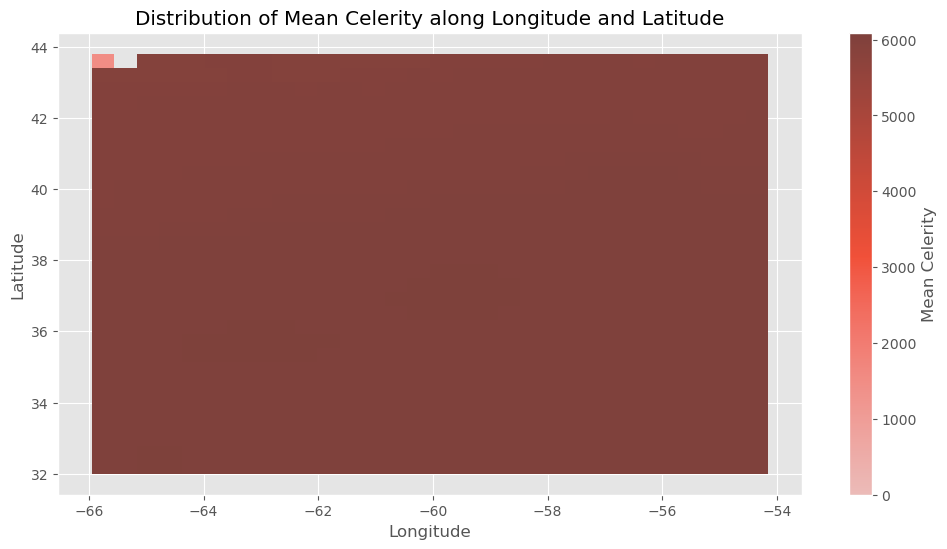

In [25]:
# Compute the mean celerity for each longitude and latitude
df_mean_celerity = df.groupby(['lon', 'lat']).mean().reset_index()

plt.figure(figsize=(12, 6))
sns.histplot(data=df_mean_celerity, x='lon', y='lat', weights='celerity',bins=30, cbar=True, cbar_kws={'label': 'Mean Celerity'})
plt.title('Distribution of Mean Celerity along Longitude and Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

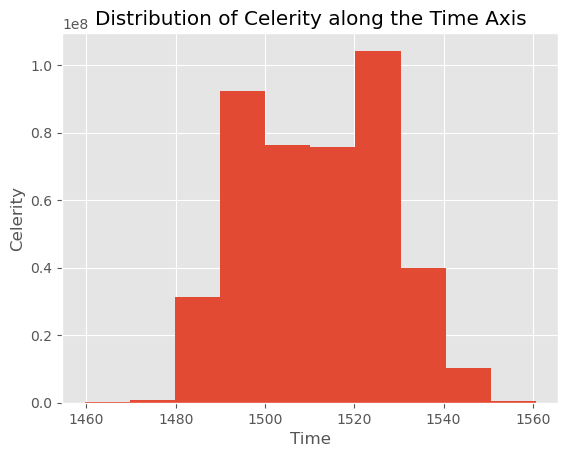

In [26]:
binned = da.isel(time=dm.train_time_idx).groupby_bins('time', bins=30).mean()

# Plot
binned.plot()
plt.title('Distribution of Celerity along the Time Axis')
plt.xlabel('Time')
plt.ylabel('Celerity')
plt.show()

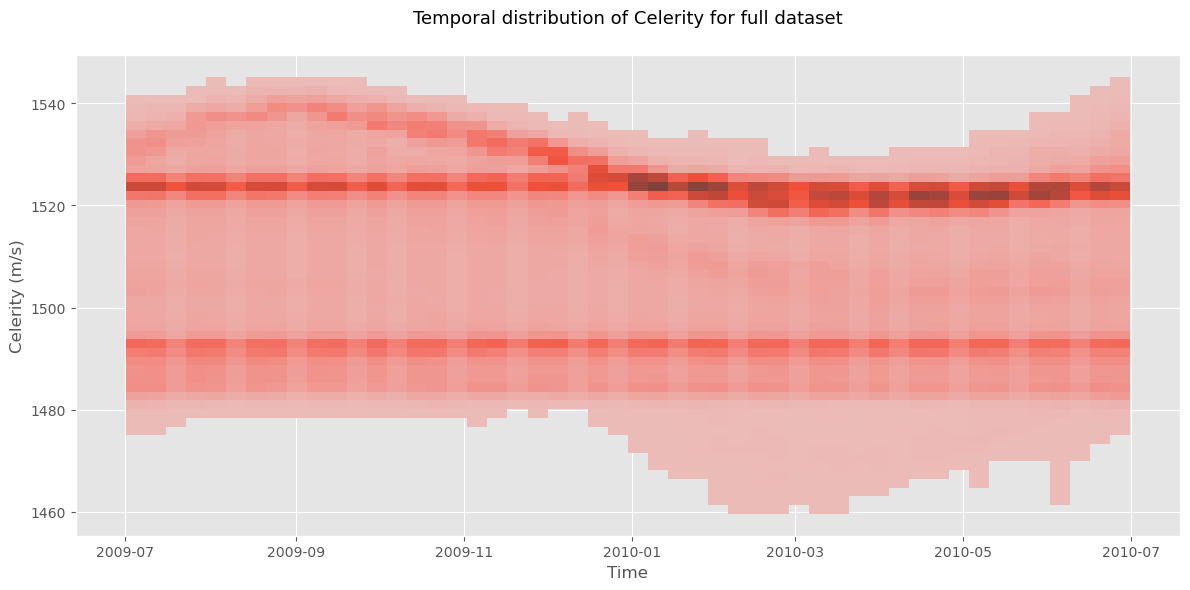

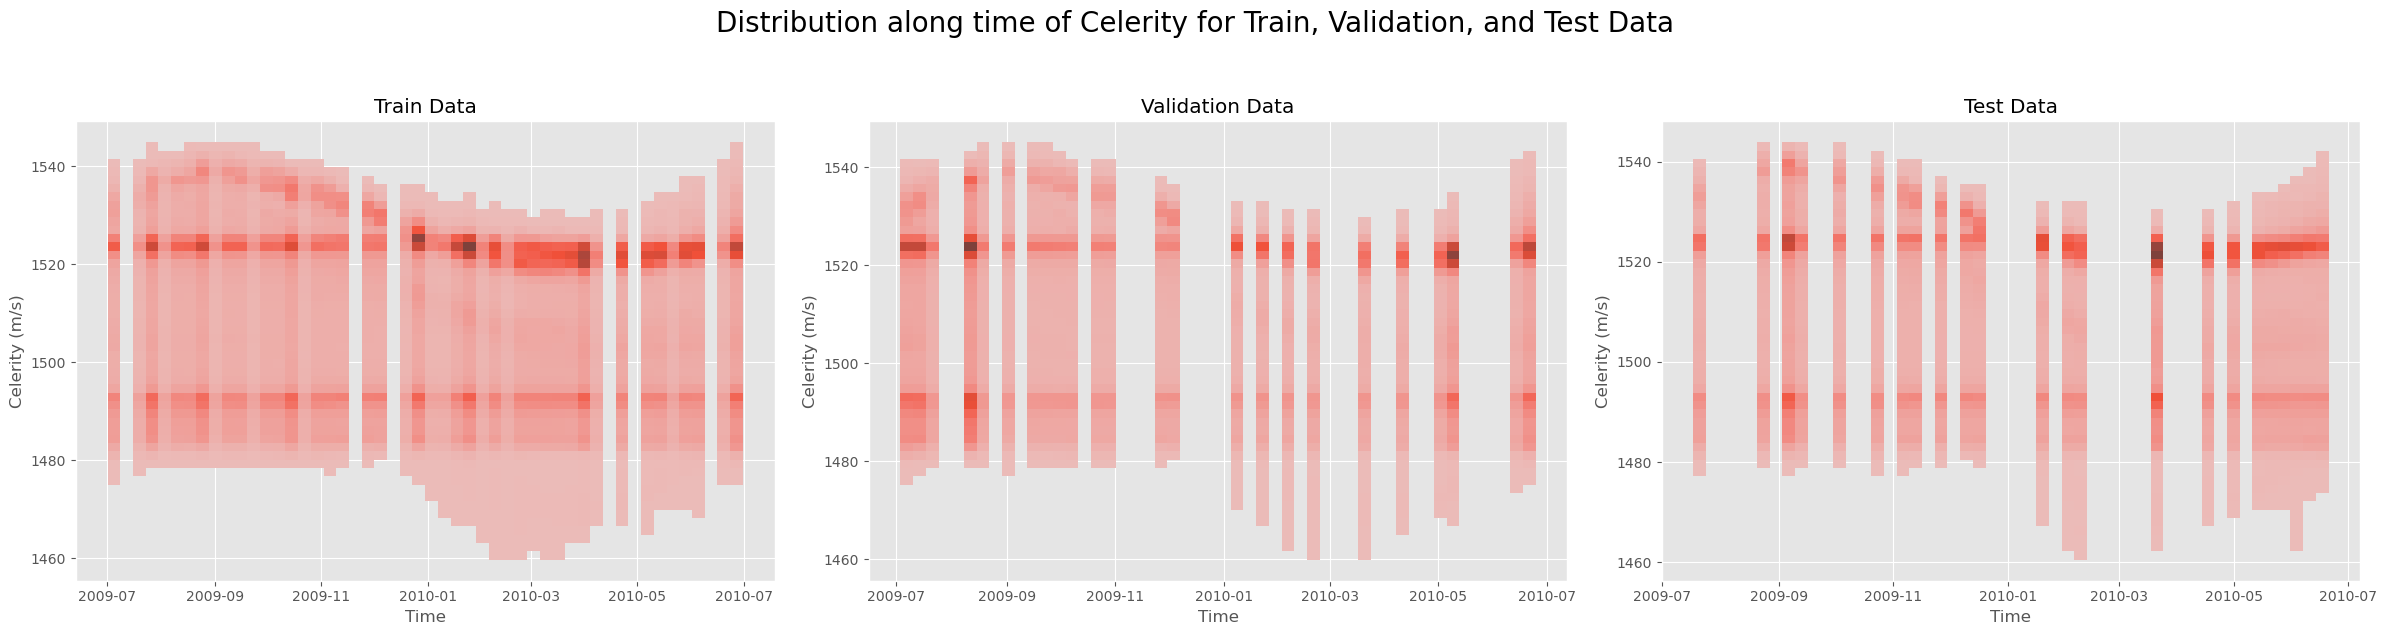

In [27]:
# Create figure for full data
fig1, ax1 = plt.subplots(figsize=(12, 6))
sns.histplot(data=df, x='time', y='celerity', bins=50, kde=True, ax=ax1)
ax1.set_title('Temporal distribution of Celerity for full dataset', fontsize=13, y=1.05)
ax1.set_xlabel('Time')
ax1.set_ylabel('Celerity (m/s)')
plt.tight_layout()
plt.show()

# Create figure for splitted data
fig2, axes2 = plt.subplots(1, 3, figsize=(24, 6))  # 1 row, 3 columns

# Plot df_train
sns.histplot(data=df_train, x='time', y='celerity', bins=50, kde=True, ax=axes2[0])
axes2[0].set_title('Train Data')
axes2[0].set_xlabel('Time')
axes2[0].set_ylabel('Celerity (m/s)')

# Plot df_val
sns.histplot(data=df_val, x='time', y='celerity', bins=50, kde=True, ax=axes2[1])
axes2[1].set_title('Validation Data')
axes2[1].set_xlabel('Time')
axes2[1].set_ylabel('Celerity (m/s)')

# Plot df_test
sns.histplot(data=df_test, x='time', y='celerity', bins=50, kde=True, ax=axes2[2])
axes2[2].set_title('Test Data')
axes2[2].set_xlabel('Time')
axes2[2].set_ylabel('Celerity (m/s)')

# Add a title to the figure
fig2.suptitle('Distribution along time of Celerity for Train, Validation, and Test Data', fontsize=20, y=1.05)

plt.tight_layout()
plt.show()


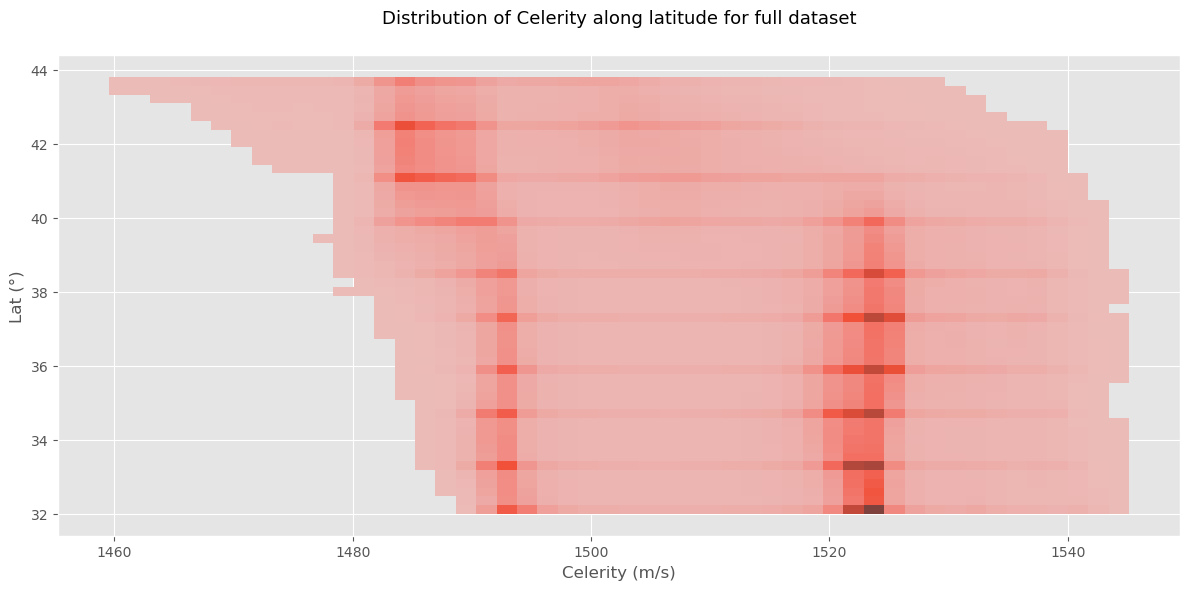

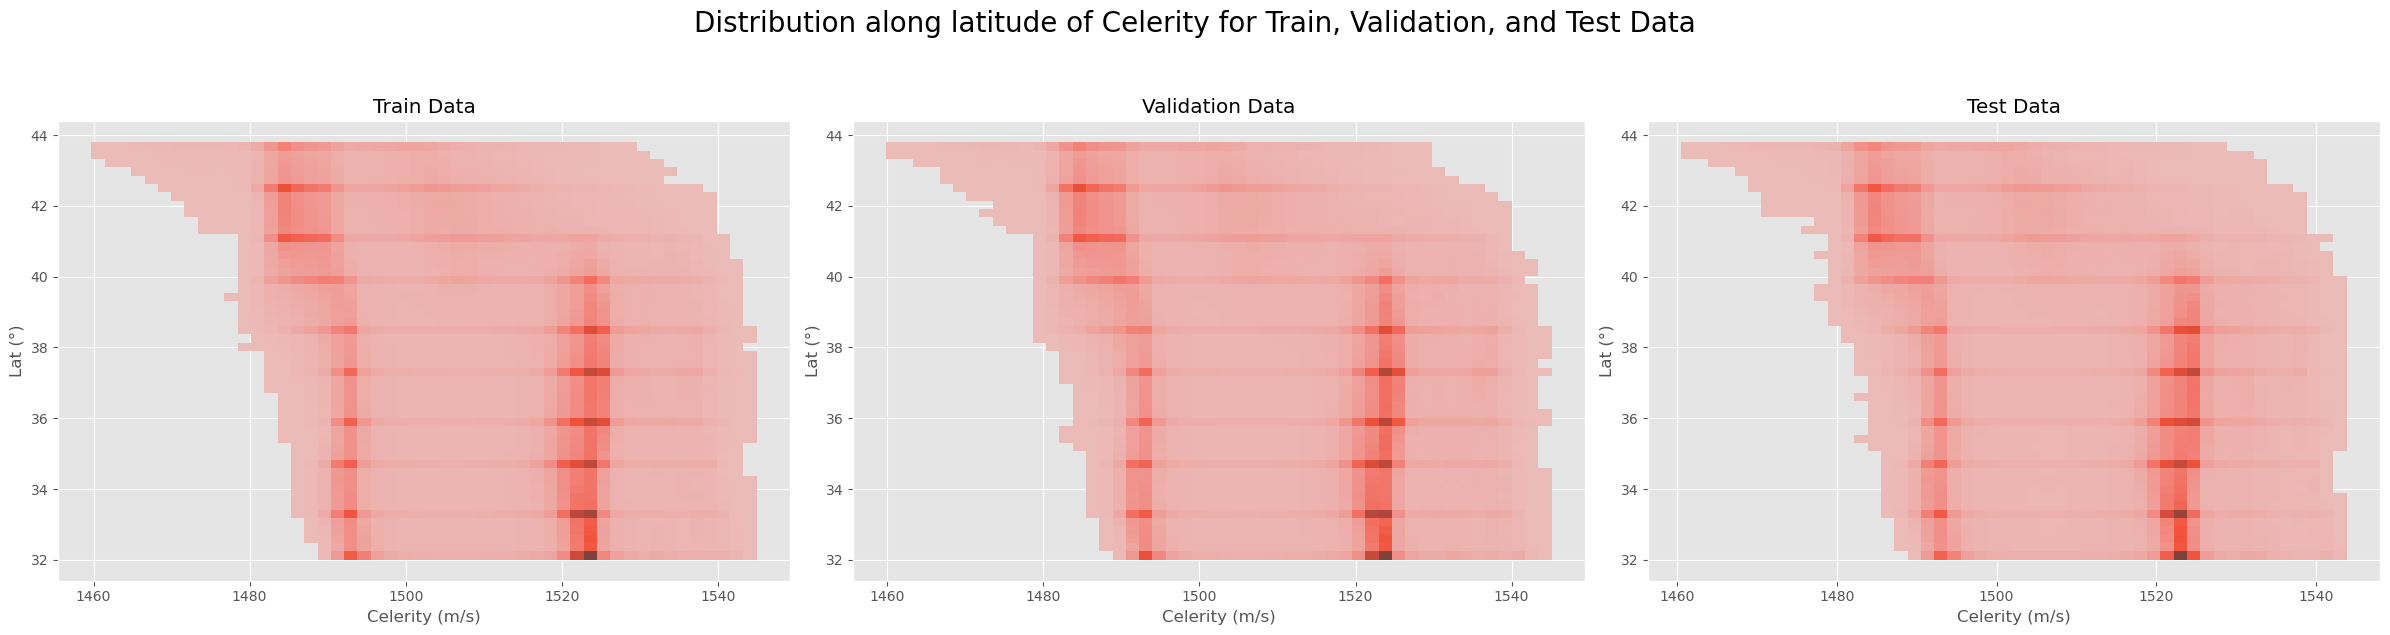

In [28]:
# Create figure for full data
fig1, ax1 = plt.subplots(figsize=(12, 6))
sns.histplot(data=df, x='celerity', y='lat', bins=50, kde=True, ax=ax1)
ax1.set_title('Distribution of Celerity along latitude for full dataset', fontsize=13, y=1.05)
ax1.set_ylabel('Lat (°)')
ax1.set_xlabel('Celerity (m/s)')
plt.tight_layout()
plt.show()

# Create figure for splitted data
fig2, axes2 = plt.subplots(1, 3, figsize=(24, 6))  # 1 row, 3 columns

# Plot df_train
sns.histplot(data=df_train, x='celerity', y='lat', bins=50, kde=True, ax=axes2[0])
axes2[0].set_title('Train Data')
axes2[0].set_ylabel('Lat (°)')
axes2[0].set_xlabel('Celerity (m/s)')

# Plot df_val
sns.histplot(data=df_val, x='celerity', y='lat', bins=50, kde=True, ax=axes2[1])
axes2[1].set_title('Validation Data')
axes2[1].set_ylabel('Lat (°)')
axes2[1].set_xlabel('Celerity (m/s)')

# Plot df_test
sns.histplot(data=df_test, x='celerity', y='lat', bins=50, kde=True, ax=axes2[2])
axes2[2].set_title('Test Data')
axes2[2].set_ylabel('Lat (°)')
axes2[2].set_xlabel('Celerity (m/s)')

# Add a title to the figure
fig2.suptitle('Distribution along latitude of Celerity for Train, Validation, and Test Data', fontsize=20, y=1.05)

plt.tight_layout()
plt.show()


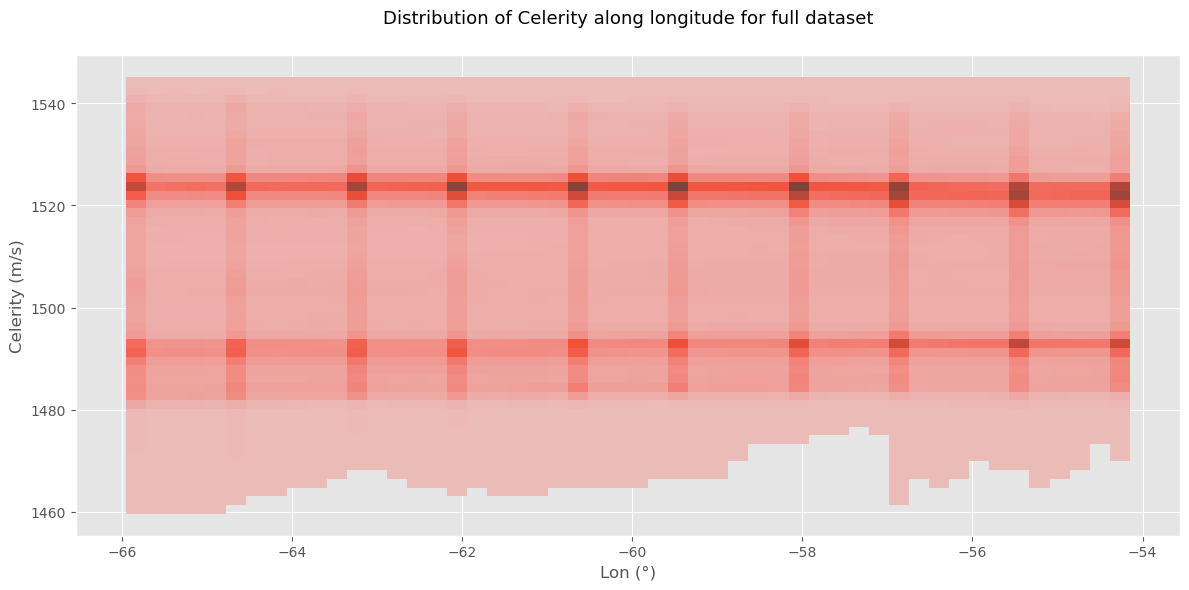

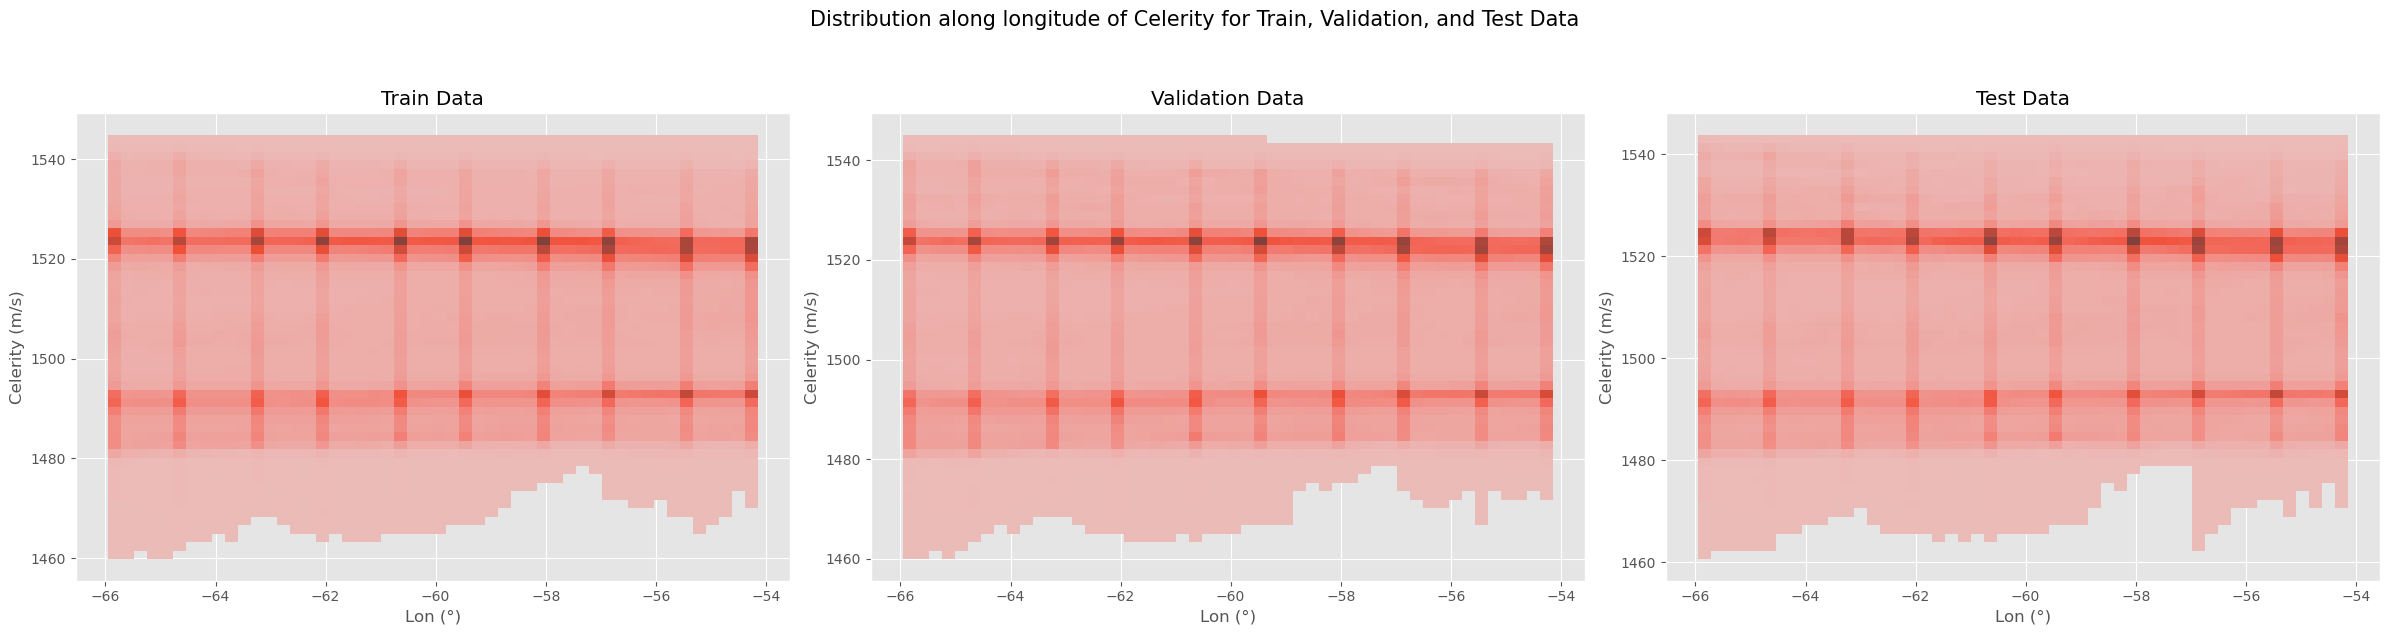

In [29]:
# Create figure for full data
fig1, ax1 = plt.subplots(figsize=(12, 6))
sns.histplot(data=df, x='lon', y='celerity', bins=50, kde=True, ax=ax1)
ax1.set_title('Distribution of Celerity along longitude for full dataset', fontsize=13, y=1.05)
ax1.set_xlabel('Lon (°)')
ax1.set_ylabel('Celerity (m/s)')
plt.tight_layout()
plt.show()

# Create figure for splitted data
fig2, axes2 = plt.subplots(1, 3, figsize=(24, 6))  # 1 row, 3 columns

# Plot df_train
sns.histplot(data=df_train, x='lon', y='celerity', bins=50, kde=True, ax=axes2[0])
axes2[0].set_title('Train Data')
axes2[0].set_xlabel('Lon (°)')
axes2[0].set_ylabel('Celerity (m/s)')

# Plot df_val
sns.histplot(data=df_val, x='lon', y='celerity', bins=50, kde=True, ax=axes2[1])
axes2[1].set_title('Validation Data')
axes2[1].set_xlabel('Lon (°)')
axes2[1].set_ylabel('Celerity (m/s)')

# Plot df_test
sns.histplot(data=df_test, x='lon', y='celerity', bins=50, kde=True, ax=axes2[2])
axes2[2].set_title('Test Data')
axes2[2].set_xlabel('Lon (°)')
axes2[2].set_ylabel('Celerity (m/s)')

# Add a title to the figure
fig2.suptitle('Distribution along longitude of Celerity for Train, Validation, and Test Data', fontsize=15, y=1.05)

plt.tight_layout()
plt.show()


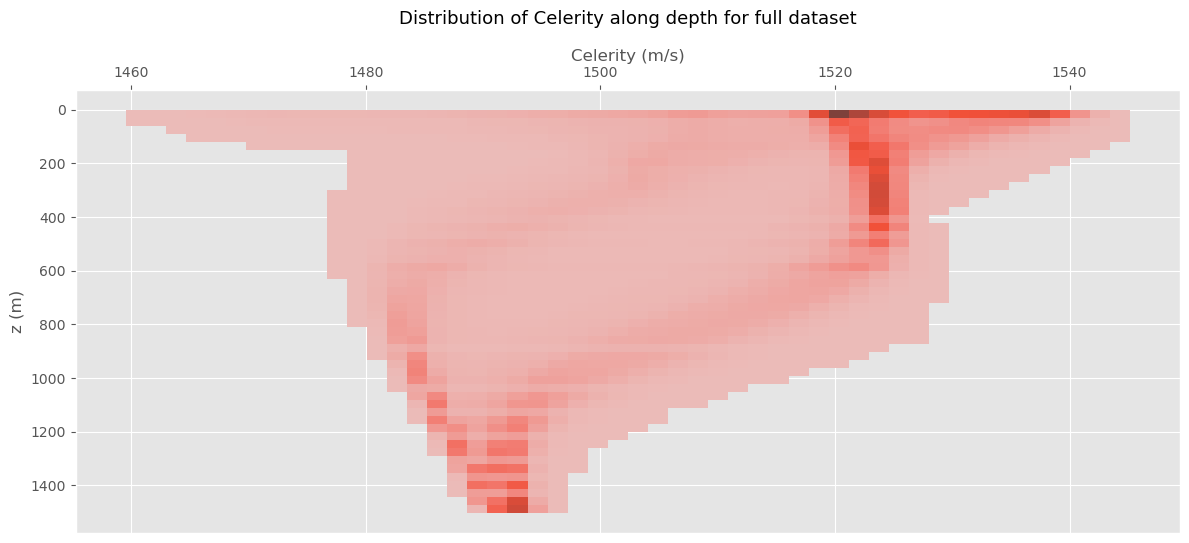

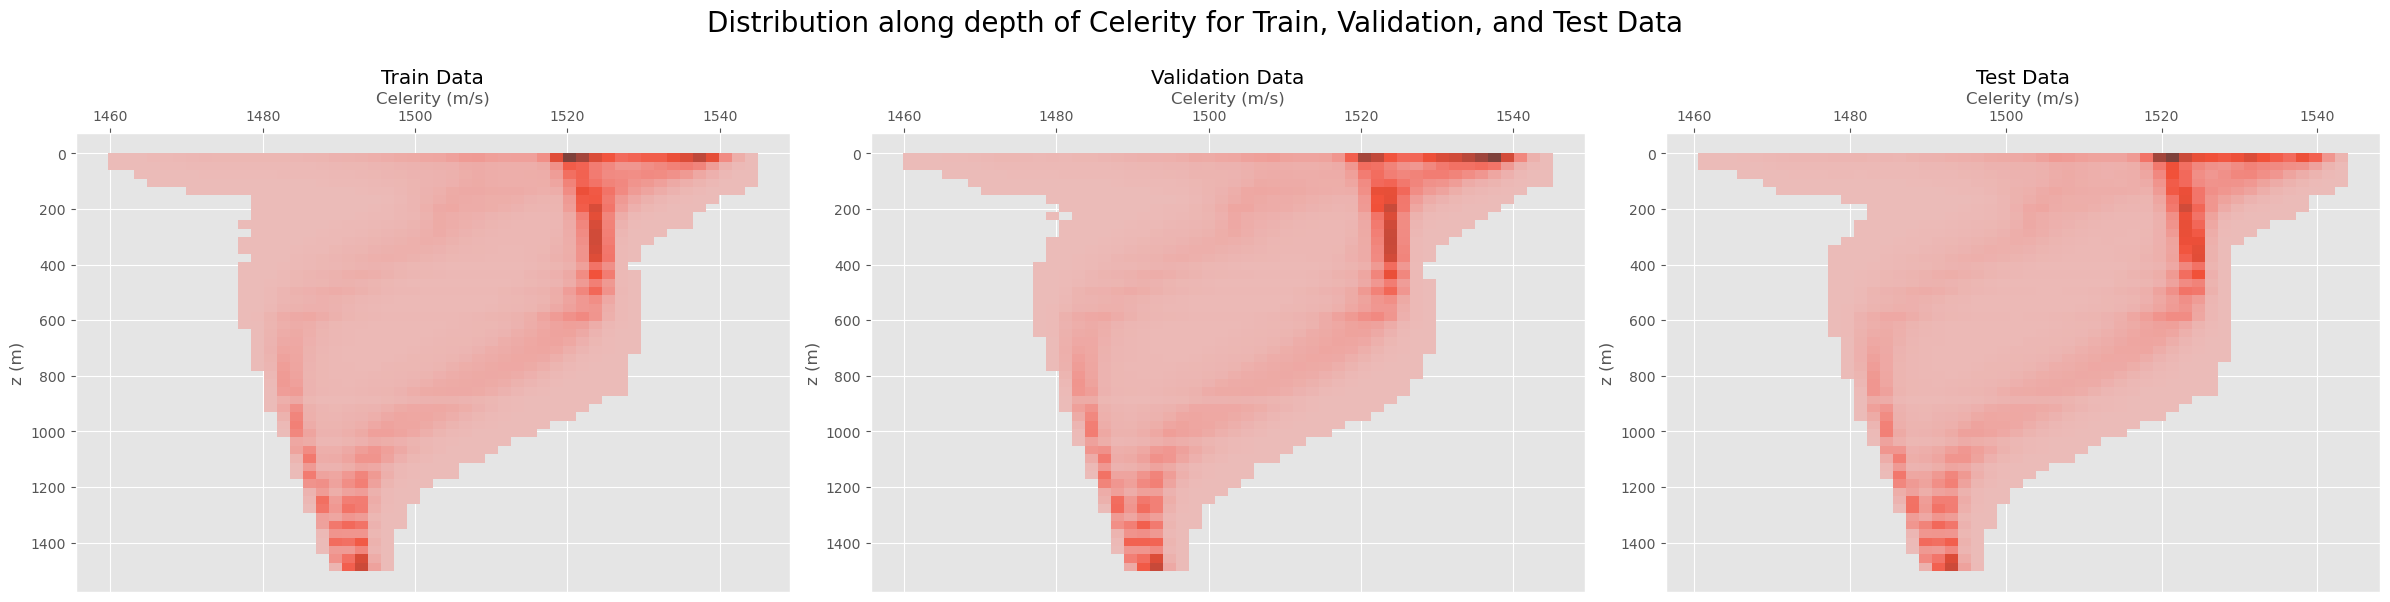

In [30]:
# Create figure for full data
fig1, ax1 = plt.subplots(figsize=(12, 6))
sns.histplot(data=df, x='celerity', y='z', bins=50, kde=True, ax=ax1)
ax1.set_title('Distribution of Celerity along depth for full dataset', fontsize=13, y=1.13)
ax1.set_ylabel('z (m)')
ax1.set_xlabel('Celerity (m/s)')
plt.tight_layout()
plt.gca().invert_yaxis()  # Invert the y-axis
plt.gca().xaxis.set_ticks_position('top')  # Set x-ticks to be above the figure
plt.gca().xaxis.set_label_position('top')  # Set x-label to be above the figure
plt.show()

# Create figure for splitted data
fig2, axes2 = plt.subplots(1, 3, figsize=(24, 6))  # 1 row, 3 columns

# Plot df_train
sns.histplot(data=df_train, x='celerity', y='z', bins=50, kde=True, ax=axes2[0])
axes2[0].set_title('Train Data')
axes2[0].set_ylabel('z (m)')
axes2[0].set_xlabel('Celerity (m/s)',y=1.03)

# Plot df_val
sns.histplot(data=df_val, x='celerity', y='z', bins=50, kde=True, ax=axes2[1])
axes2[1].set_title('Validation Data')
axes2[1].set_ylabel('z (m)')
axes2[1].set_xlabel('Celerity (m/s)',y=1.03)

# Plot df_test
sns.histplot(data=df_test, x='celerity', y='z', bins=50, kde=True, ax=axes2[2])
axes2[2].set_title('Test Data')
axes2[2].set_ylabel('z (m)')
axes2[2].set_xlabel('Celerity (m/s)',y=1.03)

# Add a title to the figure
fig2.suptitle('Distribution along depth of Celerity for Train, Validation, and Test Data', fontsize=20, y=1.07)

plt.tight_layout()

for ax in axes2:
    ax.invert_yaxis()  # Invert the y-axis
    ax.xaxis.set_ticks_position('top')  # Set x-ticks to be above the figure
    ax.xaxis.set_label_position('top')  # Set x-label to be above the figure

plt.show()


In [31]:
# plt.figure(figsize=(12, 6))
# sns.histplot(data=df, x='time', y='z', bins=30, cbar=True, cbar_kws={'label': 'Count'})
# plt.title('Distribution of Celerity along the Time and Depth Axes')
# plt.xlabel('Time')
# plt.ylabel('Depth (z)')
# plt.show()

In [32]:
# #df_melted = df_sampled.melt(id_vars=['time', 'lat', 'lon', 'z'],value_name='celerity')

# # # Downsample if the dataset is large (optional)

# df_reset = df.reset_index()  # Ensure all dimensions become columns
# df_reset

# df_sampled = df_reset.sample(n=1000, random_state=42) 

# # Pairplot to visualize the distributions
# sns.pairplot(df_sampled, vars=['time', 'lat', 'lon', 'z'], hue="celerity", diag_kind='kde')
# plt.show()

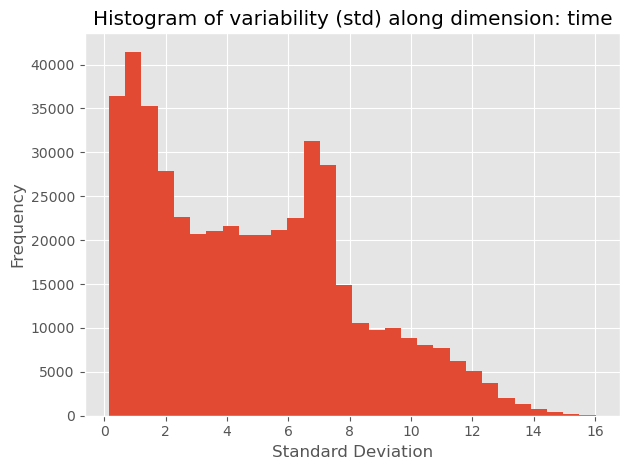

In [33]:
dim = "time"
variability = da_reduced.std(dim=dim)
plt.figure()
variability.plot.hist(bins=30)
plt.title(f'Histogram of variability (std) along dimension: {dim}')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [123]:
df = da.to_dataframe()

In [ ]:
df_std = df.groupby(['time', 'z'])['celerity'].std().reset_index(name='std_val')

plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_std, 
    x='time', 
    y='std_val', 
    bins="auto", 
    cbar=True,
    cbar_kws={'label': 'Frequency'},
    pthresh=0  # pthresh=0 ensures that bins with zero counts are shown in white
)
plt.xlabel('Time')
plt.ylabel('Standard Deviation (Spatial Variability)')
plt.title('Time vs. Standard Deviation (Facade of Spatial Variability)')
plt.tight_layout()
plt.show()


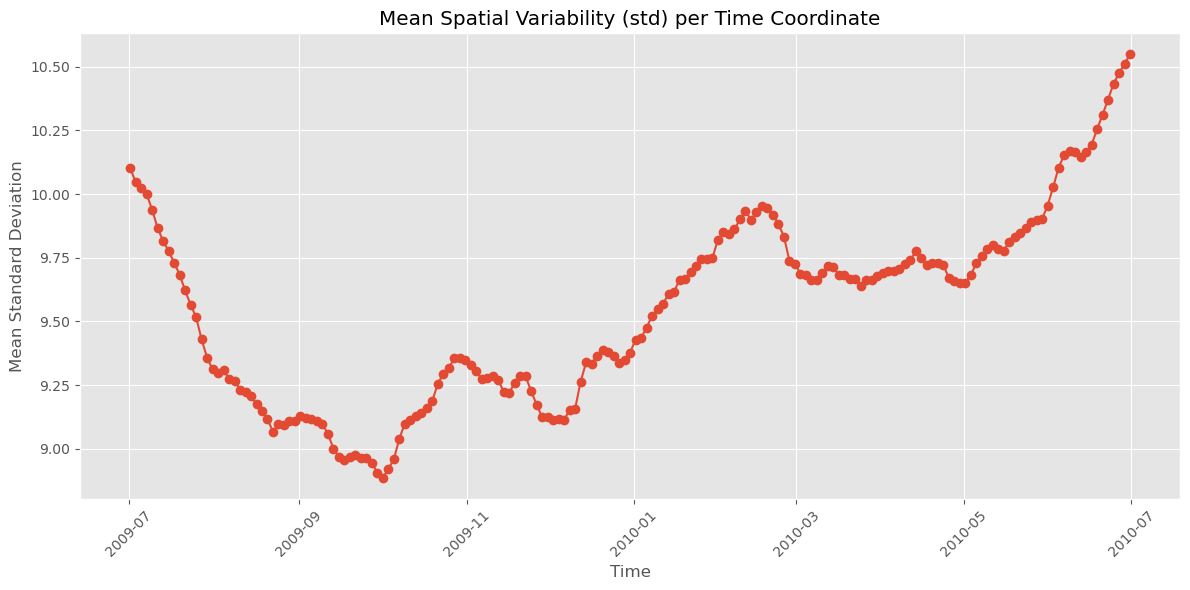

In [ ]:
df_mean_std = df_std.groupby('time')['std_val'].mean().reset_index(name='mean_std')

# Plot a line chart of mean std per time coordinate.
plt.figure(figsize=(12, 6))
plt.plot(df_mean_std['time'], df_mean_std['mean_std'], marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Mean Standard Deviation')
plt.title('Mean Spatial Variability (std) per Time Coordinate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

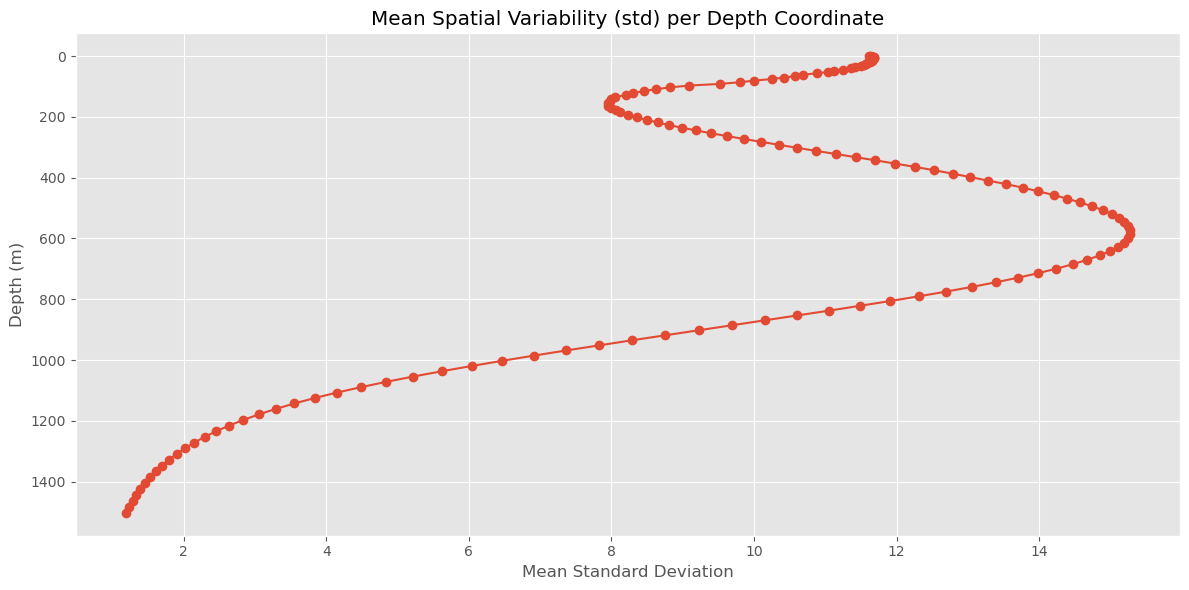

In [ ]:
df_mean_std = df_std.groupby('z')['std_val'].mean().reset_index(name='mean_std')

# Plot a line chart of mean std per depth coordinate.
plt.figure(figsize=(12, 6))
plt.plot(df_mean_std['mean_std'], df_mean_std['z'], marker='o', linestyle='-')
plt.ylabel('Depth (m)')
plt.xlabel('Mean Standard Deviation')
plt.title('Mean Spatial Variability (std) per Depth Coordinate')
plt.gca().invert_yaxis()  # Invert the y-axis
plt.tight_layout()
plt.show()

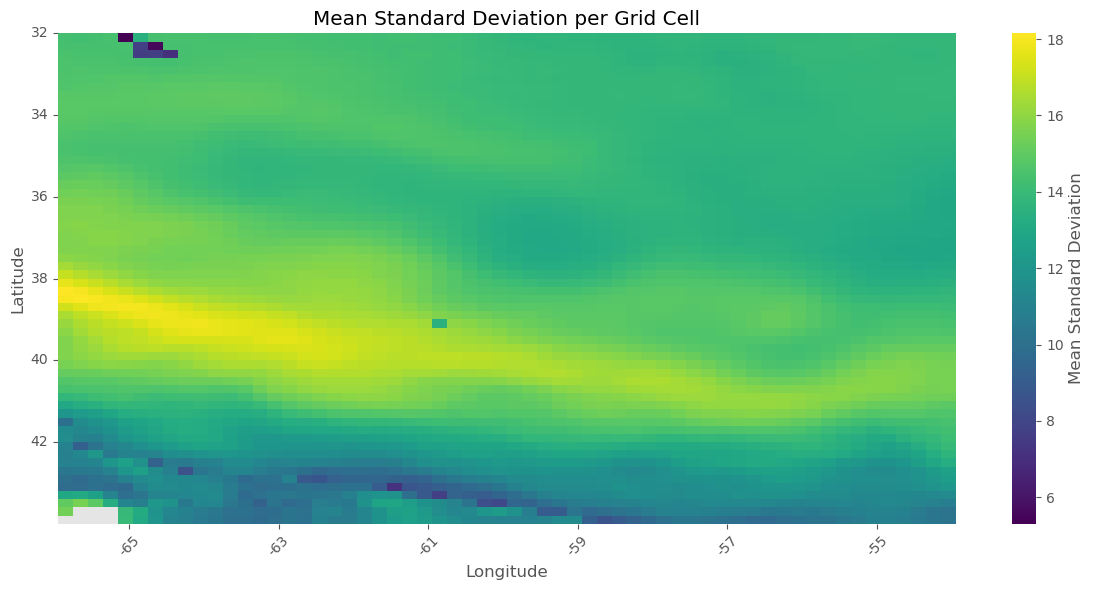

In [ ]:
df_std = df.groupby(['lat', 'lon'])['celerity'].std().reset_index(name='std_val')

# Pivot the DataFrame: rows as latitudes, columns as longitudes.
pivot_table = df_std.pivot(index='lat', columns='lon', values='std_val')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='viridis', cbar_kws={'label': 'Mean Standard Deviation'}, fmt='.1f')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
ax = plt.gca()
lon_min = pivot_table.columns.min()
lon_max = pivot_table.columns.max()

# Create tick labels every 2 integer (from min to max)
tick_labels = list(range(int(lon_min), int(lon_max)+1, 2))

# Map tick label values to their corresponding positions on the heatmap.
# The heatmap x-axis spans index positions 0 to (n-1) corresponding to pivot_table.columns (assumed sorted).
n = len(pivot_table.columns)
tick_positions = [ ((val - lon_min) / (lon_max - lon_min)) * (n - 1) for val in tick_labels ]

ax.set_xticks(tick_positions)
ax.set_xticklabels([str(tick) for tick in tick_labels], rotation=45)
lat_min = pivot_table.index.min()
lat_max = pivot_table.index.max()
tick_labels_y = list(range(int(lat_min), int(lat_max)+1, 2))
n_y = len(pivot_table.index)
tick_positions_y = [ ((val - lat_min) / (lat_max - lat_min)) * (n_y - 1) for val in tick_labels_y ]
ax.set_yticks(tick_positions_y)
ax.set_yticklabels([str(tick) for tick in tick_labels_y], rotation=0)
plt.title('Mean Standard Deviation per Grid Cell')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

DatetimeIndex(['2009-07-01 12:00:00', '2009-07-03 12:00:00',
               '2009-07-05 12:00:00', '2009-07-07 12:00:00',
               '2009-07-09 12:00:00', '2009-07-11 12:00:00',
               '2009-07-13 12:00:00', '2009-07-15 12:00:00',
               '2009-07-17 12:00:00', '2009-07-19 12:00:00',
               ...
               '2010-06-12 12:00:00', '2010-06-14 12:00:00',
               '2010-06-16 12:00:00', '2010-06-18 12:00:00',
               '2010-06-20 12:00:00', '2010-06-22 12:00:00',
               '2010-06-24 12:00:00', '2010-06-26 12:00:00',
               '2010-06-28 12:00:00', '2010-06-30 12:00:00'],
              dtype='datetime64[ns]', name='time', length=183, freq=None)


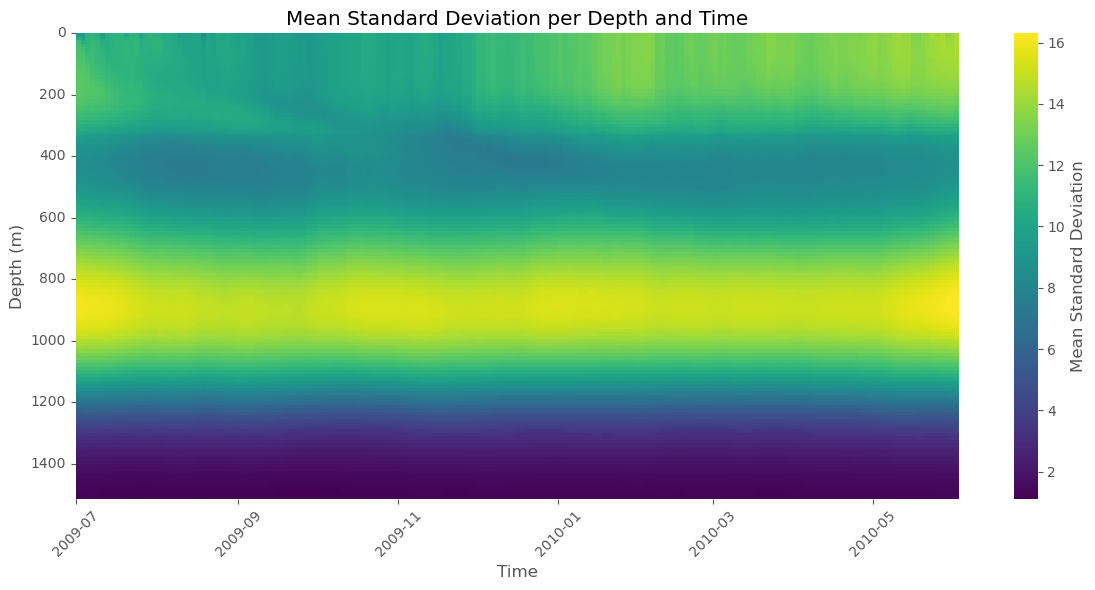

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from pandas.tseries.offsets import MonthEnd



df_std = df.groupby(['time', 'z'])['celerity'].std().reset_index(name='std_val').dropna()

# Pivot the DataFrame: rows as depth (z), columns as time.
pivot_table = df_std.pivot(index='z', columns='time', values='std_val')
print(pivot_table.columns)
pivot_table.columns = pd.to_datetime(pivot_table.columns, unit="m").strftime('%Y-%m') # Convert time to string format

pivot_table = pivot_table.sort_index(axis=1)  # Ensure columns (dates) are in chronological order

plt.figure(figsize=(12, 6))
ax = plt.gca()

# Plot the heatmap. Invert y axis to have origin (upper left).
sns.heatmap(pivot_table, cmap='viridis', cbar_kws={'label': 'Mean Standard Deviation'}, fmt='.1f', ax=ax)

# Manually set the y-ticks to ensure labels are displayed correctly
depth_min = pivot_table.index.min()
depth_max = pivot_table.index.max()
tick_labels_y = list(range(int(depth_min), int(depth_max), 200))
n_y = len(pivot_table.index)
tick_positions_y = [((val - depth_min) / (depth_max - depth_min)) * (n_y - 1) for val in tick_labels_y]
ax.set_yticks(tick_positions_y)
ax.set_yticklabels([str(tick) for tick in tick_labels_y], rotation=0)

# # Set x-axis major locator to every 4 months and format the ticks
#ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,24,3)))
date_min = pivot_table.columns.min()
date_max = pivot_table.columns.max()
tick_labels_x = pd.date_range(date_min, date_max, freq='2M').strftime('%Y-%m')
n_x = len(pivot_table.columns)
tick_positions_x = [((pd.to_datetime(val) - pd.to_datetime(date_min)).days / (pd.to_datetime(date_max) - pd.to_datetime(date_min)).days) * (n_x - 1) for val in tick_labels_x]
# x_min,x_max = ax.get_xticks()
# tick_positions_x = np.linspace(x_min,x_max,len(tick_labels_x))
ax.set_xticks(tick_positions_x)
ax.set_xticklabels(tick_labels_x, rotation=45)

# Adjust the plot to ensure all dates fit within the plot area
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Mean Standard Deviation per Depth and Time')
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.tight_layout()

# Ensure there is enough room for the ticks to display
plt.show()

DatetimeIndex(['2009-07-01 12:00:00', '2009-07-03 12:00:00',
               '2009-07-05 12:00:00', '2009-07-07 12:00:00',
               '2009-07-09 12:00:00', '2009-07-11 12:00:00',
               '2009-07-13 12:00:00', '2009-07-15 12:00:00',
               '2009-07-17 12:00:00', '2009-07-19 12:00:00',
               ...
               '2010-06-12 12:00:00', '2010-06-14 12:00:00',
               '2010-06-16 12:00:00', '2010-06-18 12:00:00',
               '2010-06-20 12:00:00', '2010-06-22 12:00:00',
               '2010-06-24 12:00:00', '2010-06-26 12:00:00',
               '2010-06-28 12:00:00', '2010-06-30 12:00:00'],
              dtype='datetime64[ns]', name='time', length=183, freq=None)


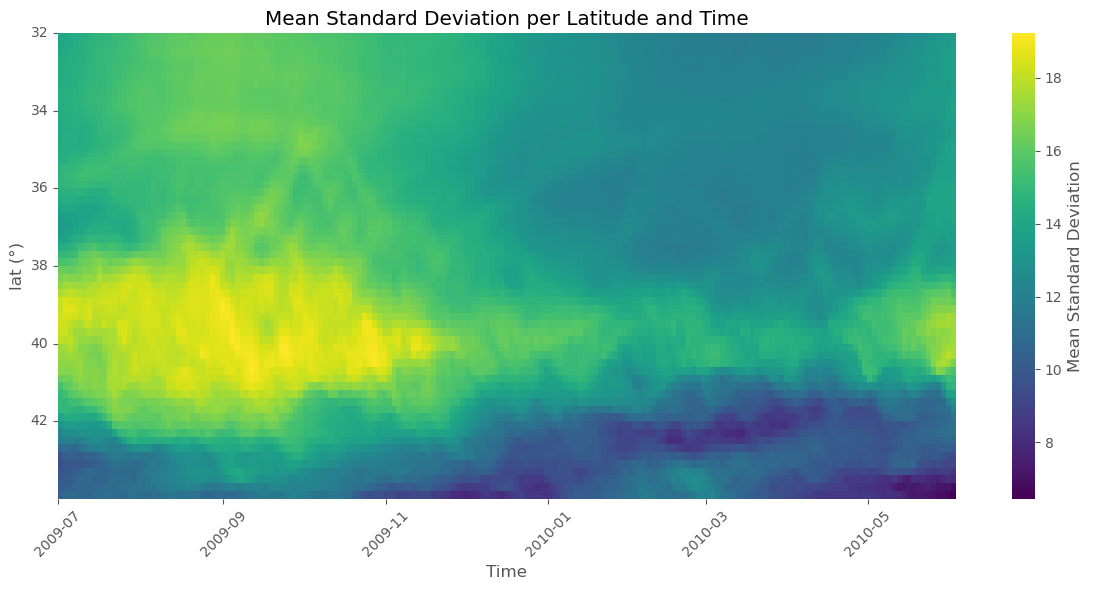

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from pandas.tseries.offsets import MonthEnd



df_std = df.groupby(['time', 'lat'])['celerity'].std().reset_index(name='std_val').dropna()

# Pivot the DataFrame: rows as lat (z), columns as time.
pivot_table = df_std.pivot(index='lat', columns='time', values='std_val')
print(pivot_table.columns)
pivot_table.columns = pd.to_datetime(pivot_table.columns, unit="m").strftime('%Y-%m') # Convert time to string format

pivot_table = pivot_table.sort_index(axis=1)  # Ensure columns (dates) are in chronological order

plt.figure(figsize=(12, 6))
ax = plt.gca()

# Plot the heatmap. Invert y axis to have origin (upper left).
sns.heatmap(pivot_table, cmap='viridis', cbar_kws={'label': 'Mean Standard Deviation'}, fmt='.1f', ax=ax)

# Manually set the y-ticks to ensure labels are displayed correctly
lat_min = pivot_table.index.min()
lat_max = pivot_table.index.max()
tick_labels_y = list(range(int(lat_min), int(lat_max), 2))
n_y = len(pivot_table.index)
tick_positions_y = [((val - lat_min) / (lat_max - lat_min)) * (n_y - 1) for val in tick_labels_y]
ax.set_yticks(tick_positions_y)
ax.set_yticklabels([str(tick) for tick in tick_labels_y], rotation=0)

# # Set x-axis major locator to every 4 months and format the ticks
#ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,24,3)))
date_min = pivot_table.columns.min()
date_max = pivot_table.columns.max()
tick_labels_x = pd.date_range(date_min, date_max, freq='2M').strftime('%Y-%m')
n_x = len(pivot_table.columns)
tick_positions_x = [((pd.to_datetime(val) - pd.to_datetime(date_min)).days / (pd.to_datetime(date_max) - pd.to_datetime(date_min)).days) * (n_x - 1) for val in tick_labels_x]
# x_min,x_max = ax.get_xticks()
# tick_positions_x = np.linspace(x_min,x_max,len(tick_labels_x))
ax.set_xticks(tick_positions_x)
ax.set_xticklabels(tick_labels_x, rotation=45)

# Adjust the plot to ensure all dates fit within the plot area
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Mean Standard Deviation per Latitude and Time')
plt.xlabel('Time')
plt.ylabel('lat (°)')
plt.tight_layout()

# Ensure there is enough room for the ticks to display
plt.show()

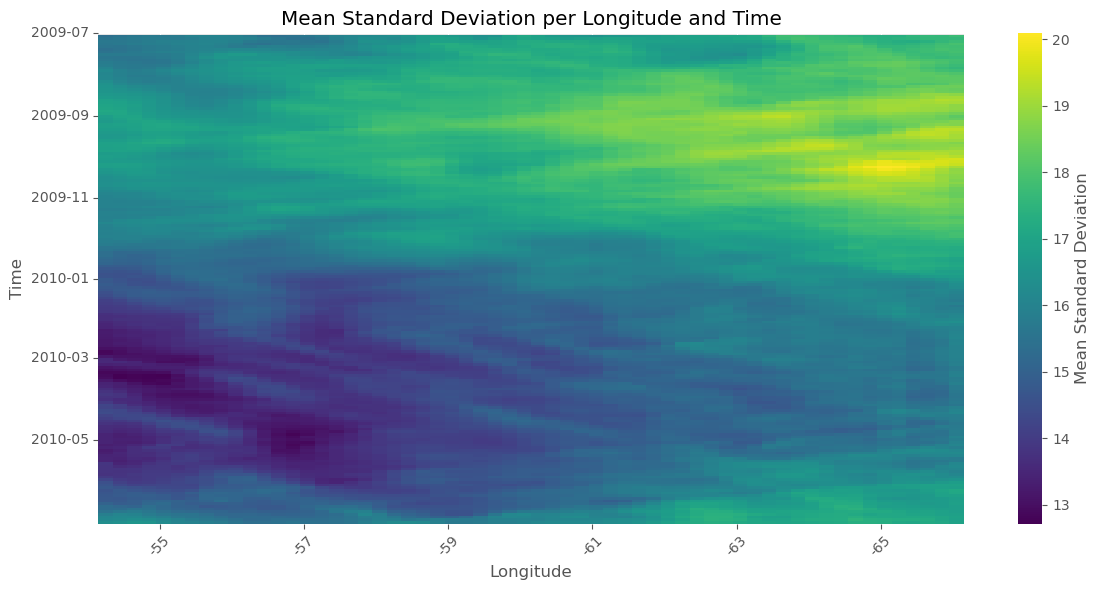

In [ ]:
df_std = df.groupby(['time', 'lon'])['celerity'].std().reset_index(name='std_val').dropna()

# Pivot the DataFrame: rows as time, columns as lon.
pivot_table = df_std.pivot(index='time', columns='lon', values='std_val')

pivot_table.columns = pivot_table.columns.astype(str)  # Convert lon to string format

pivot_table = pivot_table.sort_index(axis=1)  # Ensure columns (longitudes) are in order

plt.figure(figsize=(12, 6))
ax = plt.gca()

# Plot the heatmap.
sns.heatmap(pivot_table, cmap='viridis', cbar_kws={'label': 'Mean Standard Deviation'}, fmt='.1f', ax=ax)

# Manually set the x-ticks to ensure labels are displayed correctly
lon_min = pivot_table.columns.min()
lon_max = pivot_table.columns.max()
tick_labels_x = list(range(int(float(lon_max)), int(float(lon_min)), 2))
n_x = len(pivot_table.columns)
tick_positions_x = [((val - float(lon_min)) / (float(lon_max) - float(lon_min))) * (n_x - 1) for val in tick_labels_x]
ax.set_xticks(tick_positions_x)
ax.set_xticklabels([str(tick) for tick in tick_labels_x], rotation=45)

# Set y-axis major locator to every 2 months and format the ticks
date_min = pivot_table.index.min()
date_max = pivot_table.index.max()
tick_labels_y = pd.date_range(date_min, date_max, freq='2M').strftime('%Y-%m')
n_y = len(pivot_table.index)
tick_positions_y = [((pd.to_datetime(val) - pd.to_datetime(date_min)).days / (pd.to_datetime(date_max) - pd.to_datetime(date_min)).days) * (n_y - 1) for val in tick_labels_y]
ax.set_yticks(tick_positions_y)
ax.set_yticklabels(tick_labels_y, rotation=0)

# Adjust the plot to ensure all longitudes fit within the plot area
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Mean Standard Deviation per Longitude and Time')
plt.xlabel('Longitude')
plt.ylabel('Time')
plt.tight_layout()

# Ensure there is enough room for the ticks to display
plt.show()


Float64Index([0.4804547754091311, 1.5587915796420089,  2.794210420277172,
               4.187310545423306,  5.738673106367689,  7.448860865594492,
               9.318417912476189,  11.34786938692238, 13.537721211305469,
              15.888459830883257,
              ...
              1327.8008179141873,  1346.851256336593, 1365.9970507146836,
              1385.2371892778833, 1404.5706647425134, 1423.9964745361826,
              1443.5136210181258, 1463.1211116956615, 1482.8179594368373,
               1502.603182679468],
             dtype='float64', name='z', length=134)


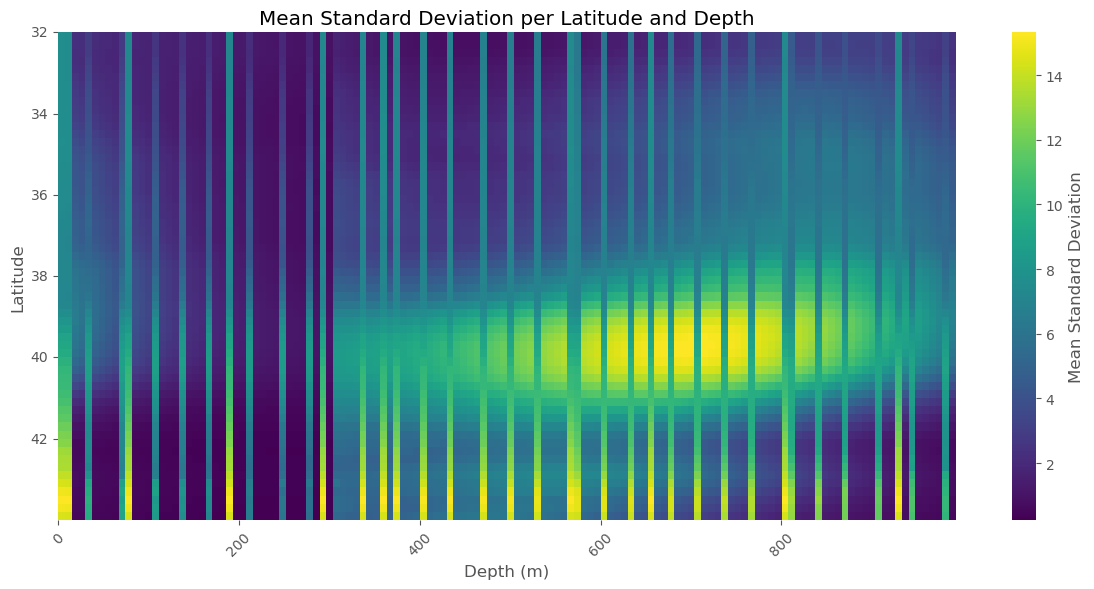

In [ ]:
df_std = df.groupby(['lat', 'z'])['celerity'].std().reset_index(name='std_val').dropna()

# Pivot the DataFrame: rows as lat, columns as depth (z).
pivot_table = df_std.pivot(index='lat', columns='z', values='std_val')
print(pivot_table.columns)
pivot_table.columns = pivot_table.columns.astype(str)  # Convert z to string format

pivot_table = pivot_table.sort_index(axis=1)  # Ensure columns (depths) are in order

plt.figure(figsize=(12, 6))
ax = plt.gca()

# Plot the heatmap.
sns.heatmap(pivot_table, cmap='viridis', cbar_kws={'label': 'Mean Standard Deviation'}, fmt='.1f', ax=ax)

# Manually set the x-ticks to ensure labels are displayed correctly
depth_min = pivot_table.columns.min()
depth_max = pivot_table.columns.max()
tick_labels_x = list(range(int(float(depth_min)), int(float(depth_max)), 200))
n_x = len(pivot_table.columns)
tick_positions_x = [((val - float(depth_min)) / (float(depth_max) - float(depth_min))) * (n_x - 1) for val in tick_labels_x]
ax.set_xticks(tick_positions_x)
ax.set_xticklabels([str(tick) for tick in tick_labels_x], rotation=45)

# Set y-axis major locator to every 2 latitudes and format the ticks
lat_min = pivot_table.index.min()
lat_max = pivot_table.index.max()
tick_labels_y = list(range(int(lat_min), int(lat_max)+1, 2))
n_y = len(pivot_table.index)
tick_positions_y = [((val - lat_min) / (lat_max - lat_min)) * (n_y - 1) for val in tick_labels_y]
ax.set_yticks(tick_positions_y)
ax.set_yticklabels(tick_labels_y, rotation=0)

# Adjust the plot to ensure all latitudes fit within the plot area
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Mean Standard Deviation per Latitude and Depth')
plt.xlabel('Depth (m)')
plt.ylabel('Latitude')
plt.tight_layout()

# Ensure there is enough room for the ticks to display
plt.show()
